In [14]:
from typing import Annotated, Literal, TypedDict
import io
import json
import time
import base64
from pprint import pprint
import traceback

import requests
from PIL import Image
from io import BytesIO
from IPython.display import display as ipy_display, Image as IPyImage
from PIL import Image
import requests
import httpx
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
# from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


BING_VISUAL_SEARCH_BASE_URI = 'https://api.bing.microsoft.com/v7.0/images/visualsearch'
BING_VISUAL_SEARCH_SUBSCRIPTION_KEY = 'ab817fc05fb84426a4df844b62b86eae'
# 可变全局变量
GLOBAL_IMAGE_URL = None
GLOBAL_IMAGE_URL = "https://test-content-public.tos-cn-shanghai.volces.com/agent/others/%E5%B7%B4%E5%8E%98%E5%B2%9B3.jpeg"


In [15]:
def print_messages(messages):
    """
    Print all messages in a list.
    """
    for message in messages:
        message.pretty_print()

In [19]:
@tool
def predict_the_weather(city_name):
    """Predict the weather of city_name today."""
    return f'根据天气网站查询，得到结果是{city_name}今天天气晴朗，微风'


@tool
def multiply_two_numbers(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b


@tool
def multiply_all_numbers(numbers) -> float:
    """multiply all numbers。计算所有数字的乘积。"""
    product = 1
    for num in numbers:
        product *= num
    return product


@tool
def sum_all_numbers(numbers) -> float:
    """Add all numbers。计算所有数字之和。"""
    return sum(numbers)


@tool
def minus(a: float, b: float) -> float:
    """Subtract two numbers. return a - b"""
    return a - b


@tool
def divide_two_numbers(a: float, b: float) -> float:
    """Divide two numbers. return a / b"""
    return a / b


@tool
def bing_visual_search():
    """利用bing搜索接口搜索给定图片链接对应的图片
    """
    global GLOBAL_IMAGE_URL
    imageUrl = GLOBAL_IMAGE_URL
    HEADERS = {'Ocp-Apim-Subscription-Key': BING_VISUAL_SEARCH_SUBSCRIPTION_KEY}
    params  = {"count": 3}

    try:
        print('*****************bing visual searching***************')
        # Download the image from the URL
        image_response = requests.get(imageUrl)
        image_response.raise_for_status()

        # Load the image into memory
        image_data = Image.open(io.BytesIO(image_response.content))

        # Resize the image to make sure its size is under 1MB
        resized_image = resize_image_to_under_1mb(image_data)

        # Convert the resized image back to bytes
        image_bytes = io.BytesIO()
        resized_image.save(image_bytes, format='JPEG')
        image_bytes.seek(0)

        # Use the resized image content directly
        file = {'image' : ('myfile', image_bytes)}

        response = requests.post(BING_VISUAL_SEARCH_BASE_URI, headers=HEADERS, files=file, params=params, timeout=8)
        response.raise_for_status()
        search_results = response.json()

        # pprint(search_results)

        # Save the search results to a JSON file
        json_filename = f'image_search_results_{int(time.time())}.json'
        with open(json_filename, 'w', encoding='utf-8') as f:
            json.dump(search_results, f, ensure_ascii=False, indent=4)

        related_prompts = extract_names(search_results)
        print('*****************searched_result****************', related_prompts)

        return related_prompts
    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed: {traceback.format_exc()}")
        print(f"Request URL: {e.request.url}")
        if e.response:
            print(f"Response status code: {e.response.status_code}")
            print(f"Response content: {e.response.text}")
    except Exception as ex:
        print(ex)
        return ''


def resize_image_to_under_1mb(image, initial_quality=85, size_decrement=0.9):
    """
    Resize an image so that its size is under 1MB by adjusting both quality and dimensions.

    :param image: PIL Image object.
    :param initial_quality: Initial quality of the image. Default is 85.
    :param size_decrement: Factor by which to decrease the size. Default is 0.9 (i.e., 10% reduction each time).
    :return: Resized PIL Image object.
    """
    def save_image_with_quality(img, quality):
        img_bytes = io.BytesIO()
        img.save(img_bytes, format='JPEG', quality=quality)
        img_bytes.seek(0)
        return img_bytes, len(img_bytes.getvalue())

    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Initial save to check size
    file_size = save_image_with_quality(image, initial_quality)[1]

    # Adjust quality first using binary search
    low_quality, high_quality = 50, initial_quality
    while file_size > 1 * 1024 * 1024 and high_quality > low_quality:
        quality = (low_quality + high_quality) // 2
        _, file_size = save_image_with_quality(image, quality)
        if file_size > 1 * 1024 * 1024:
            high_quality = quality - 1
        else:
            low_quality = quality + 1

    # If quality adjustment is not enough, start resizing
    while file_size > 1 * 1024 * 1024:
        new_size = (int(image.size[0] * size_decrement), int(image.size[1] * size_decrement))
        image = image.resize(new_size, Image.LANCZOS)
        _, file_size = save_image_with_quality(image, high_quality)

        if new_size[0] * new_size[1] < 64:
            raise ValueError("Cannot reduce image size to under 1MB without making it too small.")

    return image


# 递归提取所有的 name 和 displayName 字段
def extract_names(data, names=None, display_names=None):
    if names is None:
        names = []
    if display_names is None:
        display_names = []

    if isinstance(data, dict):
        for key, value in data.items():
            if key == 'name' and value:
                names.append(value)
            if key == 'displayName' and value:
                display_names.append(value)
            extract_names(value, names, display_names)
    elif isinstance(data, list):
        for item in data:
            extract_names(item, names, display_names)
    # names_str = ', '.join(names[:10])
    # display_names_str = ', '.join(display_names)
    recall_str = '\n'.join([f'"{n}"' for n in names[:10] + display_names]) + '\n'
    # return names_str + display_names_str +'\n'
    return recall_str


# Define the tools for the agent to use
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."


# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def agent_workflow(message, tools, thread_id=0, app=None):
    global GLOBAL_IMAGE_URL

    # 提取 image_url 并设置全局变量
    for msg in message["messages"]:
        if isinstance(msg.content, list):
            for content_item in msg.content:
                if content_item["type"] == "image_url":
                    GLOBAL_IMAGE_URL = content_item["image_url"]["url"]
                    break
            break

    if app is None:
        workflow = StateGraph(MessagesState)
        tool_node = ToolNode(tools)
        
        workflow.add_node("agent", call_model)
        workflow.add_node("tools", tool_node)
        workflow.set_entry_point("agent")
        workflow.add_conditional_edges("agent", should_continue)
        workflow.add_edge("tools", 'agent')
        checkpointer = MemorySaver()
        app = workflow.compile(checkpointer=checkpointer)
        app.get_graph().draw_png("workflow.png")

    final_state = app.invoke(message, config={"configurable": {"thread_id": thread_id}})
    # final_state["messages"][-1].pretty_print()
    print_messages(final_state["messages"])
    return final_state, app


llm = ChatOpenAI(
    openai_api_base="https://api.lingyiwanwu.com/v1", 
    openai_api_key="multimodel-peter", 
    model="gpt-4o"
    )


llm = ChatOpenAI(
    openai_api_base="https://api.lingyiwanwu.com/v1", 
    openai_api_key="multimodel-peter", 
    model="yi-vl-plus"
    )

model = llm

tools = [bing_visual_search, multiply_two_numbers, multiply_all_numbers, sum_all_numbers, divide_two_numbers, 
         minus, predict_the_weather, search
         ]
model_with_tools = model.bind_tools(tools)

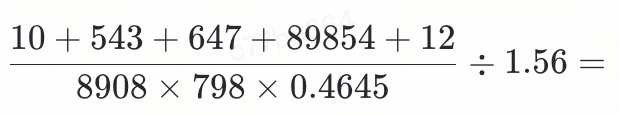

In [20]:
def display_image_from_url(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  
        image_data = BytesIO(response.content)
        try:
            from IPython import get_ipython
            ipython = get_ipython()
            if ipython is not None:
                img = IPyImage(data=response.content)
                ipy_display(img)
                return
        except ImportError:
            pass  
        img = Image.open(image_data)
        img.show()
    except requests.RequestException as e:
        print(f"Error fetching image from URL: {e}")
    except IOError as e:
        print(f"Error opening or displaying image: {e}")

# 示例使用
image_url = 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/complex_cal2.png'
display_image_from_url(image_url)


In [21]:
message = {"messages": [HumanMessage(content="计算下面所有数字之和：4654,135465,4234213,7864654,15343545。请调用工具确保计算正确。")]}    
final_state, app = agent_workflow(message=message, tools=tools, thread_id=1)
final_content = final_state["messages"][-1].content
print(final_content)


UnprocessableEntityError: Error code: 422 - {'error': {'code': 'unknown', 'message': 'try again', 'type': 'server_unavailable_error', 'param': None}}

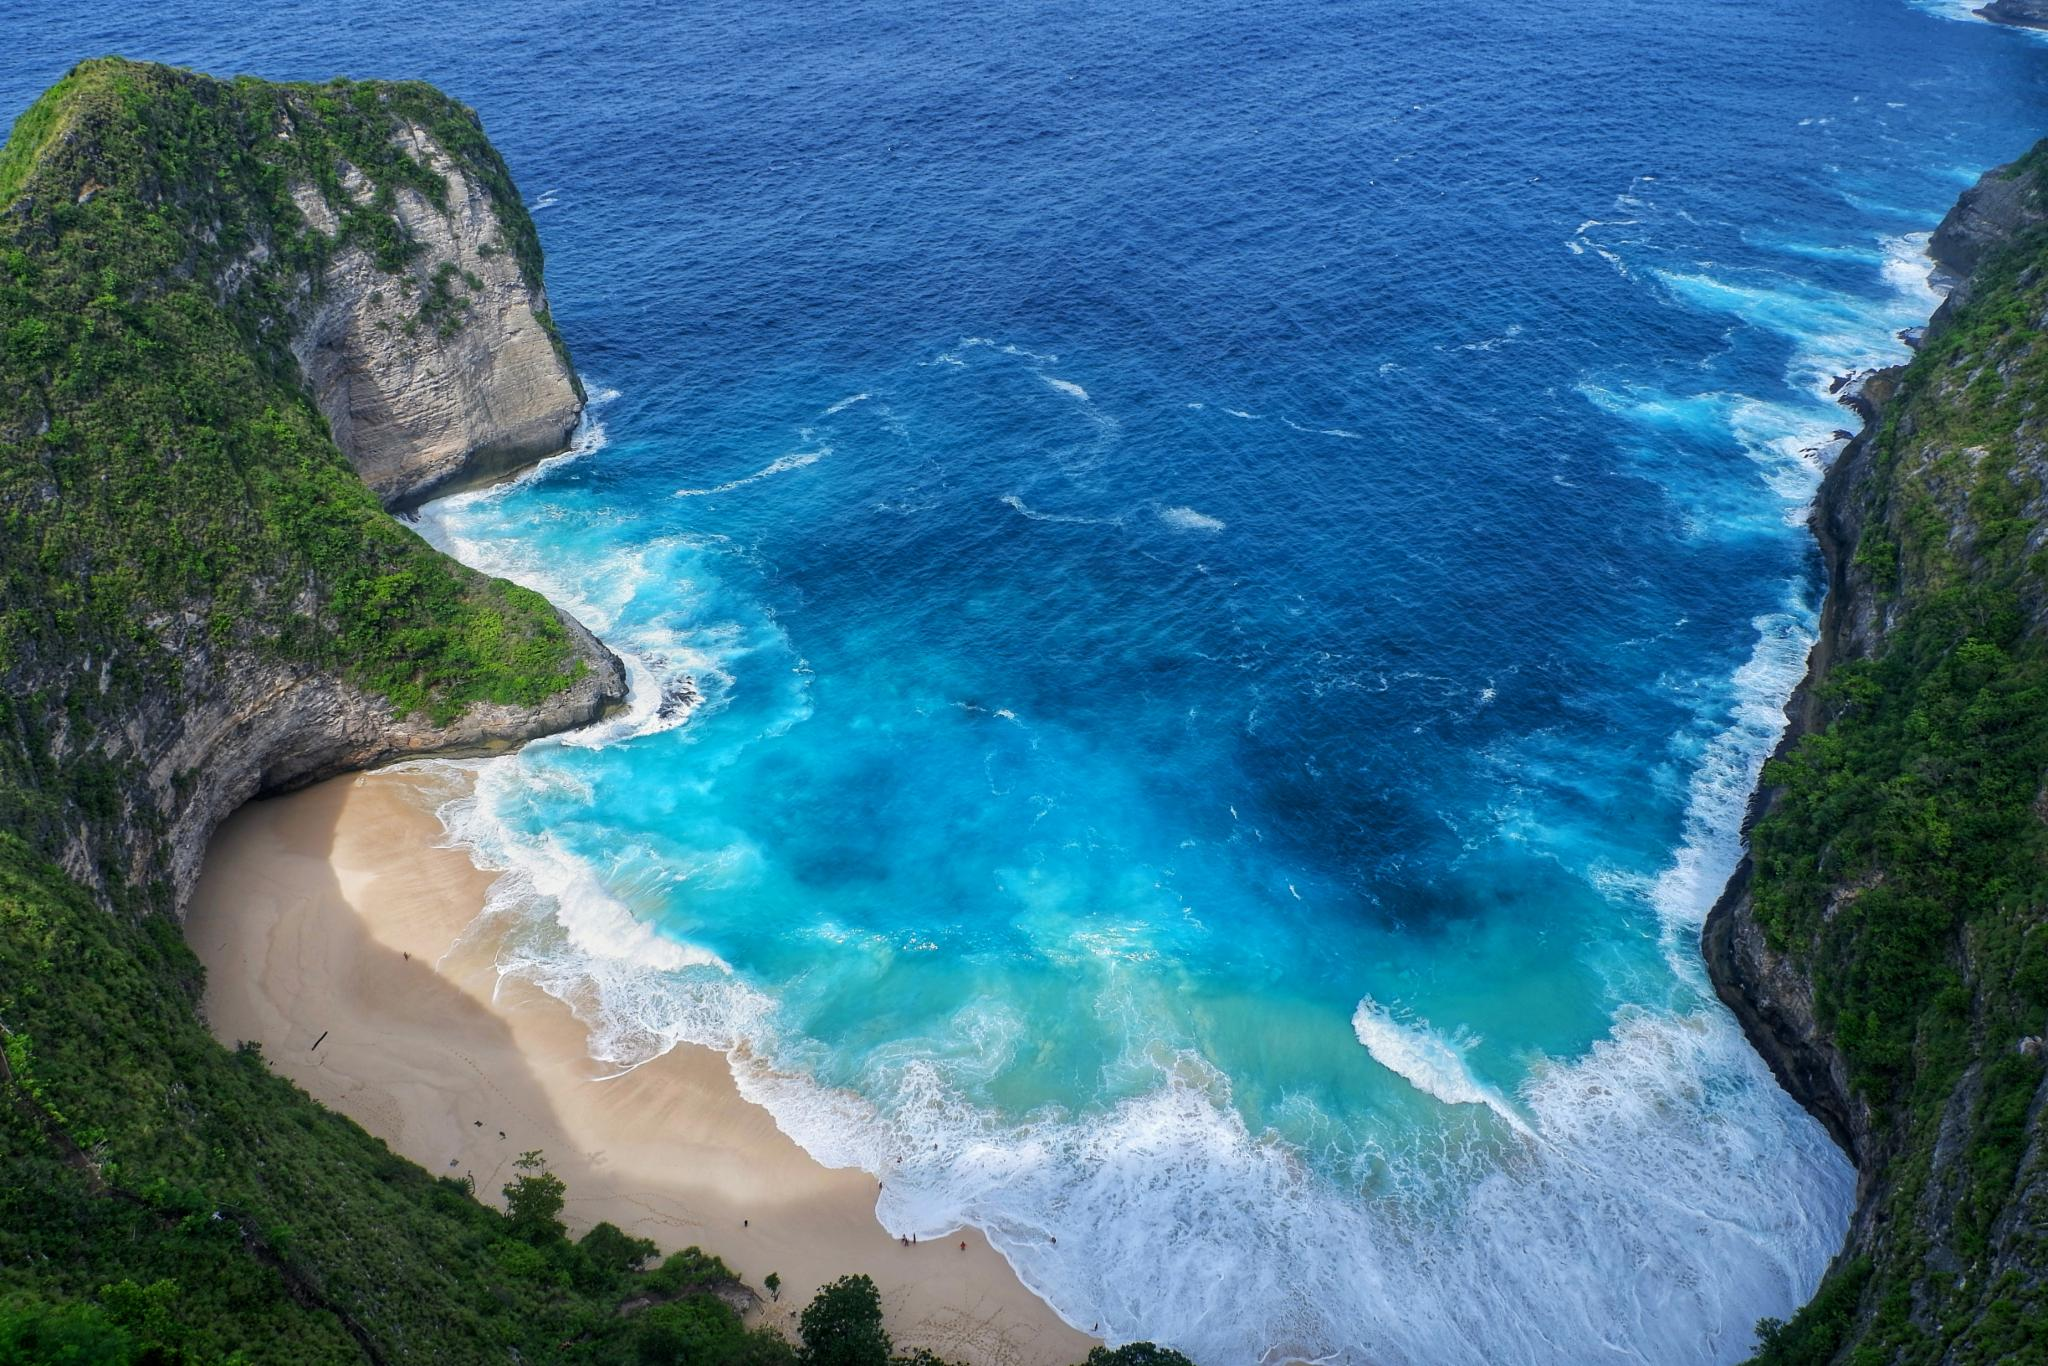

*****************bing visual searching***************
*****************searched_result**************** "巴厘岛-梦开始的地方.在异国他乡遇见你所有的美好.-巴厘岛旅游攻略-游记-去哪儿攻略"
"【乌鲁瓦图情人崖旅游】乌鲁瓦图情人崖旅游攻略，乌鲁瓦图情人崖旅游景点大全-去哪儿网"
"巴厘岛-梦开始的地方.在异国他乡遇见你所有的美好.-巴厘岛旅游攻略-游记-去哪儿攻略"
"Perfect 3-day itinerary in Nusa Penida, Indonesia | Feast of Travel"
"Indonesia ~ Martina Move"
"7 Nights in Bali - Rewards4earth.org"
"1-Day Guide to Nusa Penida Island, Indonesia - Let's Travel it Up"
"Kelingkling beach from above | Etsy"
"Bali Travel Guide & Tips | Condé Nast Traveler"
"Bali Blue Dream Beach Background, Bali, Lembongan, Beach Background ..."
"Klumbu Indonesia"

================================ Human Message =================================

[{'type': 'text', 'text': '图片中所在国家的首都今天天气怎么样？请一步一步推理，有些步骤可以调用工具，从而确保最终答案正确。'}, {'type': 'image_url', 'image_url': {'url': 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/%E5%B7%B4%E5%8E%98%E5%B2%9B3.jpeg'}}]
================================== Ai Message =====================

In [ ]:
image_url = "https://test-content-public.tos-cn-shanghai.volces.com/agent/others/%E5%B7%B4%E5%8E%98%E5%B2%9B3.jpeg"
display_image_from_url(image_url)
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
message = {"messages": [HumanMessage(content=[
    {"type": "text", "text": "图片中所在国家的首都今天天气怎么样？请一步一步推理，有些步骤可以调用工具，从而确保最终答案正确。"},
    {
        "type": "image_url",
        "image_url": {"url": image_url}
    },
]), ]}
final_state, app = agent_workflow(message=message, tools=tools, thread_id=2, app=app)
print(final_state)

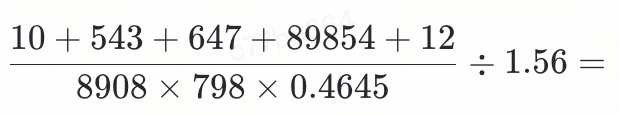

================================ Human Message =================================

[{'type': 'text', 'text': '计算这个数学公式？请一步一步推理，有些步骤可以调用工具，从而确保最终答案正确。'}, {'type': 'image_url', 'image_url': {'url': 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/complex_cal2.png'}}]
================================== Ai Message ==================================

我们可以一步一步地计算这个数学公式。公式为：

\[
\frac{10 + 543 + 647 + 89854 + 12}{8908 \times 798 \times 0.4645} \div 1.56
\]

### 步骤 1: 计算分子部分
计算分子的和：
\[ 10 + 543 + 647 + 89854 + 12 \]

我们可以调用工具来计算这个和。

### 步骤 2: 计算分母部分
计算分母的乘积：
\[ 8908 \times 798 \times 0.4645 \]

我们也可以调用工具来计算这个乘积。

### 步骤 3: 计算分数值
将步骤1的结果除以步骤2的结果。

### 步骤 4: 最后一步
将步骤3的结果再除以1.56。

我们使用工具来一步一步实现这个过程。

#### 步骤 1: 计算分子部分的和
调用工具来计算和。

#### 步骤 2: 计算分母部分的乘积
调用工具来计算乘积。

#### 步骤 3 & 4: 计算分数值和最后结果
调用工具来完成这些步骤。

我们现在开始计算。
Tool Calls:
  sum_all_numbers (call_Eu9FGytpG1DNzy5m4aFvvyaI)
 Call ID: call_Eu9FGytpG1DNzy5m4aFvvyaI
  Args:
    numbers: [10, 543, 647, 89854, 12]
  multiply_all_num

In [ ]:
image_url = 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/complex_cal2.png'
display_image_from_url(image_url)
message = {"messages": [HumanMessage(content=[
    {"type": "text", "text": "计算这个数学公式？请一步一步推理，有些步骤可以调用工具，从而确保最终答案正确。"},
    {
        "type": "image_url",
        "image_url": {"url": image_url}
    },
]), ]}
final_state, app = agent_workflow(message=message, tools=tools, thread_id=3, app=app)


In [ ]:
(10 + 543 + 647 + 89854 + 12) / (8908 * 798 * 0.4645) / 1.56

0.0176792095935243

In [ ]:
message = {"messages": [HumanMessage(content=[
    {"type": "text", "text": "我对羊奶过敏。"},
]), ]}
final_state, app = agent_workflow(message=message, tools=tools, thread_id=4, app=app)
final_content = final_state["messages"][-1].content

================================ Human Message =================================

[{'type': 'text', 'text': '我对羊奶过敏。'}]
================================== Ai Message ==================================

了解了，对于羊奶过敏的人来说，避免食用羊奶制品非常重要。如果你有任何疑问或需要建议，请随时告诉我。


In [ ]:
# image_url = 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/elderly_goat_milk_powder1.jpeg'
# display_image_from_url(image_url)
message = {"messages": [HumanMessage(content=[
    {"type": "text", "text": "刚刚让你计算的数字结果是什么来着？"},
]), ]}
final_state, app = agent_workflow(message=message, tools=tools, thread_id=3, app=app)
final_content = final_state["messages"][-1].content


================================ Human Message =================================

[{'type': 'text', 'text': '刚刚让你计算的数字结果是什么来着？'}]
================================== Ai Message ==================================

不好意思，我这里没有存储之前的对话记录。请问可以再告诉我一遍需要计算的数字吗？我可以重新帮助你计算。
================================ Human Message =================================

[{'type': 'text', 'text': '刚刚让你计算的数字结果是什么来着？'}]
================================== Ai Message ==================================

我无法查看之前的对话记录，因此无法知道你之前让我计算的数字结果是什么。如果你能提供具体的数字或操作步骤，我可以重新为你进行计算。


In [ ]:
message = {"messages": [HumanMessage(content=[
    {"type": "text", "text": "我的基本信息：65岁，对羊奶、鸡蛋过敏。"},
]), ]}
final_state, app = agent_workflow(message=message, tools=tools, thread_id=6, app=app)

================================ Human Message =================================

[{'type': 'text', 'text': '我的基本信息：65岁，对羊奶、鸡蛋过敏。'}]
================================== Ai Message ==================================

了解了您的基本信息。如果您有任何需求或问题，请随时告诉我。无论是健康建议、食谱推荐，还是其他任何问题，我都会尽力帮助您。


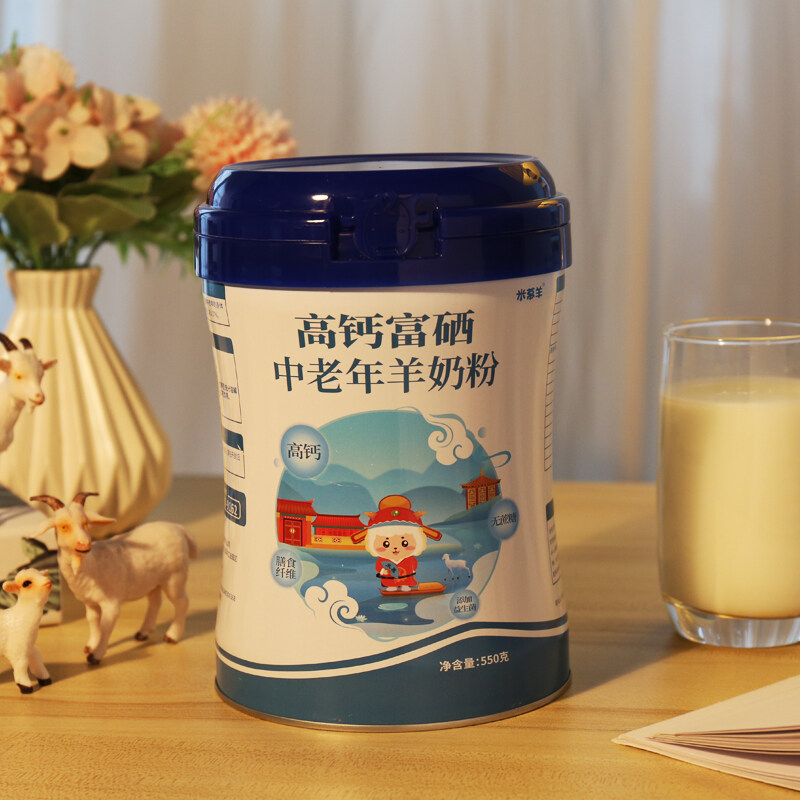

================================ Human Message =================================

[{'type': 'text', 'text': '我的基本信息：65岁，对羊奶、鸡蛋过敏。'}]
================================== Ai Message ==================================

了解了您的基本信息。如果您有任何需求或问题，请随时告诉我。无论是健康建议、食谱推荐，还是其他任何问题，我都会尽力帮助您。
================================ Human Message =================================

[{'type': 'text', 'text': '今天朋友家孩子送了一个产品给我，帮我看看适合我吗？'}, {'type': 'image_url', 'image_url': {'url': 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/elderly_goat_milk_powder1.jpeg'}}]
================================== Ai Message ==================================

根据您提供的信息，您对羊奶过敏，而这个产品是“中老年羊奶粉”。因此，这个产品可能不适合您饮用，因为它含有羊奶成分，可能会引发过敏反应。

建议您避免食用该产品，并选择适合您的其他替代品。如果您有其他需要或疑问，请随时告知。


In [ ]:
image_url = 'https://test-content-public.tos-cn-shanghai.volces.com/agent/others/elderly_goat_milk_powder1.jpeg'
display_image_from_url(image_url)
message = {"messages": [HumanMessage(content=[
    {"type": "text", "text": "今天朋友家孩子送了一个产品给我，帮我看看适合我吗？"},
    {
        "type": "image_url",
        "image_url": {"url": image_url}
    },
]), ]}
final_state, app = agent_workflow(message=message, tools=tools, thread_id=6, app=app)
final_content = final_state["messages"][-1].content
